In [1]:
import numpy as np
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import pImpactR as impact
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
def getH(x,y):
    z = x+1j*y
    U = z/np.sqrt(1-z*z)*np.arcsin(z)
    U = U.real
    return 0.5*(x*x+y*y) + 0.4*U

In [3]:
def getI(x,y):
    z = x+1j*y
    W = 2*x/np.sqrt(1-z*z)*np.arcsin(z)
    W = W.real
    return x*x + 0.4*W

In [4]:
def I2Hobj(x):
    measI = getI(x[0],x[1])
    measH = getH(x[0],x[1])
    return (measI-2*measH)**2

In [5]:
from scipy.optimize import minimize
arc = []
for i in range(64):
    x = 0.65*np.random.rand() + 0.35
    y = np.sqrt(2*(x-0.35))
    result = minimize(I2Hobj,[0.4+0.02*i,0.01+0.04*i],tol=1.0e-10)
    if result.x[1] > 1.0e-4 and result.fun < 1.0e-16:        
        arc.append(result.x)

(-1, 1)

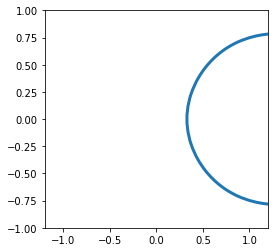

In [6]:
arc = np.array(arc)
arc = np.sort(arc,axis=0)
arc2 = arc[::-1,:].copy()
arc2[:,1] = -arc2[:,1]
n=len(arc)
arc3 = np.zeros([2*n,2])
arc3[n:,:] =arc
arc3[:n,:] =arc2
arc2 = None
arc = arc3
arc3 = None

plt.figure(figsize=(4,4))
plt.plot(arc[:,0],arc[:,1],lw=3)
plt.xlim(-1.2,1.2)
plt.ylim(-1,1)

In [7]:
import pickle
data   = pickle.load(open('FMA.data.pickle','rb'))
dataFB = pickle.load(open('FB.data.pickle','rb'))

data.update(dataFB)

In [8]:
data.keys()

dict_keys(['FMA.T=128', 'FMA.T=256', 'FB.T=128', 'FB.T=256'])

In [9]:
beam, lattice = impact.readInputFile('../test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3034496449165134
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

reading ImpactZ input file (../test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [10]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)

In [11]:
npt_Test = 3834
pData = impact.readParticleData(111110,ke,mass,freq,format_id=2,fileLoc='/128/')[npt_Test:,:]
normalize(pData)

In [12]:
counts,xbins,ybins=np.histogram2d(pData[:,0],pData[:,2],bins=16)

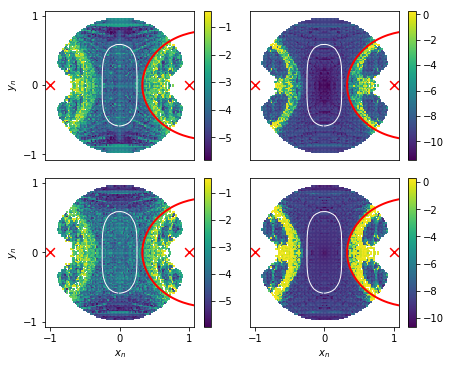

In [13]:
n = 1024
fig = plt.figure(figsize=[6.4,5.2])
cmap = [0]*4
for i,n in enumerate([128,256]):
    plt.subplot(2,2,1+2*i)
    deco = 'FMA.T='+str(n)
    cmap[2*i]=plt.scatter(data[deco]['X'],data[deco]['Y'],c=data[deco]['c'],s=1.0,marker='s')
    plt.scatter(data[deco]['X'],-data[deco]['Y'],c=data[deco]['c'],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,colors='white',linestyles='solid',levels=[1450])
    
    if i==1:
        plt.xticks([-1,0,1])
    else:
        plt.xticks([])
    plt.yticks([-1,0,1])
    plt.xlim(-0.98*1.1,0.98*1.1)
    plt.ylim(-0.98*1.1,0.98*1.1)
    if i==1:
        plt.xlabel('$x_n$')  
    plt.ylabel('$y_n$')
    plt.colorbar(cmap[2*i])
    
    plt.subplot(2,2,2+2*i)
    deco = 'FB.T='+str(n)
    cmap[2*i+1]=plt.scatter(data[deco]['X'],data[deco]['Y'],c=data[deco]['c'],s=1.0,marker='s')
    plt.scatter(data[deco]['X'],-data[deco]['Y'],c=data[deco]['c'],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,colors='white',linestyles='solid',levels=[1450])
    if i==1:
        plt.xticks([-1,0,1])
    else:
        plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.98*1.1,0.98*1.1)
    plt.ylim(-0.98*1.1,0.98*1.1)
    if i==1:
        plt.xlabel('$x_n$')  
    plt.colorbar(cmap[2*i+1])
plt.tight_layout()
plt.savefig('First256turn.FMA.FB.png',dpi=270)
plt.savefig('First256turn.FMA.FB.eps',dpi=270)